## Convnet Adventures 

### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gzip
#import cPickle
import pickle as pkl
import os,re
from torch.nn.init import kaiming_normal_,kaiming_uniform_
from functools import partial
import math,pdb

### Reading Data 

In [3]:
datapath = Path('data/cifar-10-batches-py')

In [4]:
!ls {datapath}

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [4]:
#with gzip.open(datapath/'cifar-10-python.tar.gz','rb') as f:
#    pass

In [5]:
#with gzip.open(datapath/'cifar-10-python.tar.gz','rb') as f:
#    data = pkl.load(f,encoding='latin')

In [5]:
fnames=list(datapath.iterdir())

In [6]:
!ls {datapath/'data_batch_1/'}

data/cifar-10-batches-py/data_batch_1


In [7]:
def load_file(file):
    with open(file,'rb') as f:
        data = pkl.load(f,encoding='bytes')
    return data[b'data'],data[b'labels']

In [8]:
x,y=load_file(datapath/'data_batch_1')

In [9]:
trn_data=[]
trn_y=[]
for f in fnames:
    if re.search(r'data_',str(f)):
        x,y = load_file(f)
        trn_data.append(x)
        trn_y.append(y)
        

In [13]:
trn_data = np.vstack(trn_data)
trn_y = np.concatenate(trn_y)

In [12]:
trn_data.shape,trn_y.shape

((50000, 3072), (50000,))

In [15]:
def show_img(arr,axs=None):
    if axs is None:
        fig,axs =plt.subplots(figsize=(8,4))
    axs.imshow(arr.reshape(3,32,32).transpose(1,2,0))    
    axs.set_xticks([])
    axs.set_yticks([])
    return axs

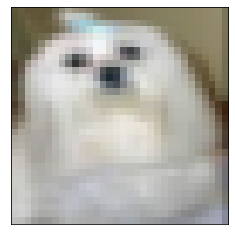

In [16]:
_=show_img(trn_data[1])


### Dataset and Dataloader Definition 

In [17]:
class Dataset:
    def __init__(self,x,y):
        self.x,self.y=x,y
        if not isinstance(self.x,torch.Tensor):
            self.x= torch.tensor(x,dtype=torch.float32)
            self.y=torch.tensor(y)
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return len(self.x)

In [52]:
class Sampler:
    def __init__(self,ds,bs,shuffle=True):
        self.ds,self.bs,self.shuffle=ds,bs,shuffle
    def __len__(self):
        return len(self.ds)
    def __iter__(self):
        if self.shuffle:
            idxs=torch.randperm(len(self))
        else:
            idxs=torch.arange(len(self))
        for i in range(0,len(self),self.bs):
            yield idxs[i:i+self.bs]

In [53]:
def collate_fn(xy):
    x,y=zip(*xy)
    return torch.stack(x),torch.stack(y)
class DataLoader:
    def __init__(self,sampler,ds,collate_fn=collate_fn):
        self.sampler,self.ds,self.collate_fn=sampler,ds,collate_fn
    def __iter__(self):
        for idxs in self.sampler:
            yield self.collate_fn([self.ds[i] for i in idxs]) 
    def __len__(self):
        return len(self.sampler)

### Splitting Data
20% to validation set

In [54]:
n=len(trn_data)
idxs = np.arange(n)
np.random.shuffle(idxs)
prop=0.2
val_bound = int(0.2*n)
x_train,y_train = trn_data[:-val_bound],trn_y[:-val_bound]
x_valid,y_valid = trn_data[-val_bound:],trn_y[-val_bound:]


### Dataset Initialization

In [55]:
trn_ds = Dataset(x_train,y_train)
val_ds = Dataset(x_valid,y_valid)
tsmplr = Sampler(trn_ds,bs=128)
vsmplr = Sampler(val_ds,bs=256,shuffle=False)
trn_dl = DataLoader(tsmplr,trn_ds,collate_fn)
val_dl = DataLoader(vsmplr,val_ds,collate_fn)

## Model Building

In [25]:
class NNModel(nn.Module):
    def __init__(self,ni,no,nhs=[128,128]):
        super().__init__()
        self.lyrs = nn.ModuleList()
        for i,h in enumerate(nhs[:-1]):
            if i==0:
                self.lyrs.append(nn.Linear(ni,h))
            else:
                self.lyrs.append(nn.Linear(h,nhs[i+1]))
        self.lyrs.append(nn.Linear(nhs[-1],no))
    def forward(self,x):
        for l in self.lyrs[:-1]:
            x=F.relu(l(x))
        x=self.lyrs[-1](x)
        return x
        

In [26]:
nc=trn_y.max().item()+1
mymod = NNModel(trn_data.shape[1],nc)

In [27]:
class ConvLayer:
    pass
class ResBlock:
    pass
class ConvModel:
    pass

## Training Loop 

In [28]:
def scheduler(f):
    def _inner(start,stop):
        return partial(f,start,stop)
    return _inner
@scheduler
def sched_lin(start,stop,pos):
    return start + pos*(stop-start)
@scheduler
def sched_cos(start,stop,pos):
    return (start+stop)/2 + (start-stop)/2*(math.cos(math.pi*pos))

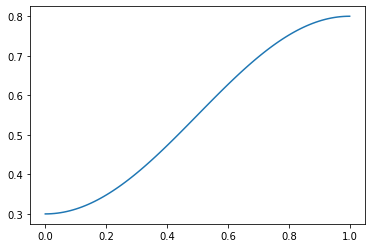

In [25]:
f=sched_cos(0.3,0.8)
pos = np.linspace(0,1,100)
evals = [f(p) for p in pos]
plt.plot(pos,evals)
plt.show()

In [33]:
def comb_sched(sched_funcs,sched_threshs):
    """
    Functions takes a list of schedulers and the threshold till which each should be enabled
    """
    #checking that max threshold be less than 1
    assert np.max(sched_threshs)<=1.
    #checking if the length of functions should match the length of thresholds
    assert len(sched_funcs)==len(sched_threshs)
    # add 0 as first threshold
    sched_threshs=np.array([0]+list(sched_threshs))
    def _inner(pos):
        #check the position of threshold
        idx = (pos > sched_threshs).nonzero()
        if len(idx[0])!=0:
            idx=idx[0][-1]
        else:
            idx=0
            
        new_pos = (pos-sched_threshs[idx])/(sched_threshs[idx+1]-sched_threshs[idx])
        return sched_funcs[idx](new_pos)
    return _inner
        
        

In [49]:
sched_funcs = [sched_cos(0.3,0.8),sched_lin(0.8,0.3),sched_lin(0.3,0.1)]
sched_threshs=[0.4,0.8,1.]
cs =comb_sched(sched_funcs,sched_threshs)

In [50]:
cs(0)

0.30000000000000004

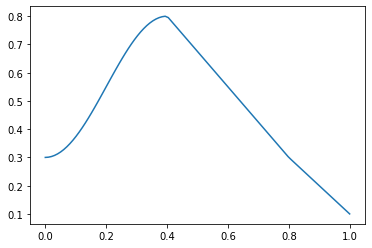

In [51]:
f=cs
pos = np.linspace(0.0,1,100)
evals = [f(p) for p in pos]
plt.plot(pos,evals)
plt.show()

In [59]:
def listify(x):
    """
    Function to convert anything to list
    """
    if x is None: x= []
    elif isinstance(x,str): x=[x]
    elif hasattr(x,'__iter__'): x=list(x)
    else: x=[x]
    return x
#class to handle all the callbacks
class CallbackHandler:
    def _init__(self,cbs):
        self.cbs=listify(cbs)
    def __call__(self,name,trainer):
        for c in sorted(self.cbs,key=lambda x: x._order):
            k = getattr(c,name)
            if k:
                k(trainer)
#Learning rate finder
class LRFinder:
    _order=1
    def __init__(self,min_lr=1e-6,max_lr=10,min_loss=1e10,max_iters=200):
        self.lr_min,self.lr_max,self.min_loss=min_lr,max_lr,min_loss
        self.lrs=[]
        self.losses=[]
        self.max_iters = max_iters
        self.iters=0
    def begin_fit(self,trainer):
        trainer.iters=0
    def begin_batch(self,trainer):
        pos = trainer.iters/self.max_iters
        trainer.lr = self.lr_min*(self.lr_max/self.lr_min)**pos
    def after_loss(self,trainer):
        self.losses.append(trainer.loss)
        if trainer.loss > self.min_loss*10:
            trainer.stop=True
        if self.min_loss > trainer.loss:
            self.min_loss=trainer.loss
        self.iters+=1
class Recorder:
    def __init__(self,smoothing=0.1):
        self.smoothing=smoothing
    def begin_fit(self,trainer):
        self.lrs=[]
        self.losses=[]
    def after_batch(self,trainer):
        self.lrs.append(trainer.lr)
        self.losses.append(trainer.loss)
    def plot(self,skip_last=-1):
        slosses=[]
        for i,l in enumerate(self.losses):
            if i==0:
                slosses.append(l)
            else:
                temp = slosses[i-1]+self.smoothing*(l-slosses[i-1])
                slosses.append(temp)
                
            
        
        

class ParamScheduler:
    _order=1
    def __init__(self,opt,pname,funcs):
        funcs = listify(funcs)
        if len(funcs)!=len(opt.param_groups):
            funcs = funcs*len(opt.param_groups)
        self.pname,self.funcs=pname,funcs
    def begin_batch(self,trainer):
        pos = trainer.iters/trainer.tot_iters
        for pg in enumerate(trainer.opt.param_groups):
            pg[self.pname]=self.funcs[i](pos)

            
def accuracy(preds,y):
    preds=torch.argmax(preds,dim=-1)
    return (preds==y).float().mean().cpu().item()
            
class StatsCalc:
    def __init__(self,metrics=[accuracy]):
        self.metrics=metrics
        
    def reset(self):
        self.tot_loss=0
        self.metstats=[0]*len(self.metrics)
        self.count=0
    
    def update(self,trainer):
        bs = trainer.xb.shape[0]
        self.count+=bs
        self.tot_loss+=bs*trainer.loss
        for i,m in enumerate(self.metrics):
            self.metstats[i]+=bs*m(self.preds,self.yb)
    
    def __repr__(self):
        print(self.tot_loss/self.count)
        for m in self.metstats:
            print(m/self.count)

class StatsRecorder:
    
    def __init__(self,trainstats,validstats):
        self.trainstats,self.validstats=trainstats,validstats
        
    def begin_epoch(self,trainer):
        self.trainstats.reset()
        self.validstats.reset()
        
    def after_batch(self,trainer):
        if trainer.training:
            self.trainstats.update(trainer)
        else:
            self.validstats.update(trainer)
            
    def after_epoch(self,trainer):
        print(f"Training stats:{self.trainstats}\n")
        print(f"Validation stats:{self.validstats}\n")

In [60]:
class DataBunch:
    def __init__(self,train_dl,valid_dl):
        self.train_dl,self.valid_dl  = train_dl,valid_dl
    

In [61]:
class Trainer:
    def __init__(self,model,db,loss_func,opt):
        self.model,self.db,self.loss_func,self.opt=model,db,loss_func,opt
        
    def one_batch(self,xb,yb):
        self.xb,self,yb=xb,yb
        self("begin_batch")
        self.preds = self.model(self.xb)
        self("after_loss")
        self.loss = self.loss_func(self.preds,self.yb)
        self("after_loss")
        self.loss.backward()
        self("after_backward")
        self.opt.step()
        self.opt.zero_grad()
        self("after_batch")
        
    def all_batches(self,mode='training'):
        if mode=='training':
            self.model.train()
            dl=self.db.train_dl
        else:
            self.model.eval()
            dl=self.db.valid_dl
        for xb,yb in dl:
            self.one_batch(xb,yb)
        
    def fit(self,nepochs,cbh=None):
        self.nepochs=nepochs
        self.cbh=cbh
        self("begin_fit")
        for epoch in range(epochs):
            self.training=True
            self.epoch=epoch
            self("begin_epoch")
            self.all_batches(mode='training')
            self("begin_validation")
            with torch.no_grad():
                self.validation=True
                self.all_batches(mode='validation')
            self("after_epoch")      
    def __call__(self,name):
        if self.cbh:
            self.cbh(name,self)
            

In [62]:
db = DataBunch(train_dl=trn_dl,valid_dl=val_dl)

In [63]:
next(iter(db.valid_dl))[1].shape

torch.Size([256])

In [ ]:
cbs = [LRFinder(),]